In [308]:
import torch
import torchvision
import torchvision.transforms as transforms

Train dataset has 62743 examples


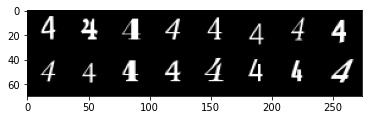

torch.Size([128, 1, 32, 32])


In [309]:
import PIL
import os
import pathlib

torch.manual_seed(42)

class FlatImageFolder(torch.utils.data.Dataset):
    def __init__(self, path, transform):
        self._path = pathlib.Path(path)
        self._transform = transform
        self._image_paths = list(self._path.iterdir())
        
    def __len__(self):
        return len(self._image_paths)
    
    def __getitem__(self, idx):
        with open(self._image_paths[idx], 'rb') as f:
            img = PIL.Image.open(f)
            img = img.convert("L")
            
            return self._transform(img)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((3, 3, 4, 4)),
#     transforms.Normalize((0.5), (0.5)),
])

train_dataset = FlatImageFolder("/data/datasets/fonts/rendered/numbers_small/4", transform)
print(f"Train dataset has {len(train_dataset)} examples")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=10)
train_iter = iter(train_loader)
train_images = train_iter.next()

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
#     img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(train_images[:16]))
print(train_images.shape)

In [310]:
import torch.nn as nn
import torch.nn.functional as F

# class Net(nn.Module):
#     def __init__(self, latent_dim = 2):
#         super(Net, self).__init__()
#         self.latent_dim = 2
# #         self.relu=nn.LeakyReLU(.2)
#         self.relu = F.relu
#         self.conv1 = nn.Conv2d(1, 6, 3, padding=1, stride=2) # 32
#         self.conv2 = nn.Conv2d(6, 12, 3, padding=1, stride=2) # 16
# #         self.conv3 = nn.Conv2d(12, 24, 3, padding=1, stride=2) # 8
# #         self.conv4 = nn.Conv2d(24, 48, 3, padding=1, stride=2) # 4
# #         self.fc1 = nn.Linear(48 * 4 * 4, self.latent_dim)
        
# #         self.fc2 = nn.Linear(self.latent_dim, 48 * 4 * 4)
# #         self.tconv1 = nn.ConvTranspose2d(48, 24, 3, stride=2, padding=1, output_padding=1) # 8
# #         self.tconv2 = nn.ConvTranspose2d(24, 12, 3, stride=2, padding=1, output_padding=1) # 16
#         self.tconv3 = nn.ConvTranspose2d(12, 6, 3, stride=2, padding=1, output_padding=1) # 32
#         self.tconv4 = nn.ConvTranspose2d(6, 1, 3, stride=2, padding=1, output_padding=1) # 64
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, x):
    
#         # Encode
#         x = self.relu(self.conv1(x))
#         print(f"Conv1: [{x.min().item():.2f}, {x.max().item():.2f}], ", end = "")
#         x = self.relu(self.conv2(x)) 
#         print(f"Conv2: [{x.min().item():.2f}, {x.max().item():.2f}], ", end = "")
# #         x = F.relu(self.conv3(x)) 
# #         x = F.relu(self.conv4(x)) 
# #         x = x.view(-1, 48 * 4 * 4)
# #         x = F.relu(self.fc1(x))
                
# #         # Decode
# #         x = F.relu(self.fc2(x))
# #         x = x.view(-1, 48, 4, 4)
# #         x = F.relu(self.tconv1(x))
# #         x = F.relu(self.tconv2(x))
#         x = self.relu(self.tconv3(x))
#         print(f"TConv3: [{x.min().item():.2f}, {x.max().item():.2f}], ", end = "")
# #         x = self.relu(self.tconv4(x))
#         x = self.tconv4(x)
#         print(f"TConv4: [{x.min().item():.2f}, {x.max().item():.2f}], ", end = "")
#         x = self.sigmoid(x)
#         print(f"Sigmoid: [{x.min().item():.3f}, {x.max().item():.3f}], ", end = "")
#         print()

#         return x
    
# https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential( # like the Composition layer you built
#             nn.Conv2d(1, 16, 3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(16, 32, 3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, 7)
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(64, 32, 7),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

net = Autoencoder()
# net = Net()
n = net(train_images)
print("Batch output shape:", n.shape)
print()

for i, p in enumerate(net.parameters()):
    print("Parameters", i, p.size())
print("Trainable parameters:", sum([p.numel() for p in net.parameters()]))

Batch output shape: torch.Size([128, 1, 32, 32])

Parameters 0 torch.Size([16, 1, 3, 3])
Parameters 1 torch.Size([16])
Parameters 2 torch.Size([32, 16, 3, 3])
Parameters 3 torch.Size([32])
Parameters 4 torch.Size([64, 32, 3, 3])
Parameters 5 torch.Size([64])
Parameters 6 torch.Size([128, 64, 3, 3])
Parameters 7 torch.Size([128])
Parameters 8 torch.Size([128, 64, 3, 3])
Parameters 9 torch.Size([64])
Parameters 10 torch.Size([64, 32, 3, 3])
Parameters 11 torch.Size([32])
Parameters 12 torch.Size([32, 16, 3, 3])
Parameters 13 torch.Size([16])
Parameters 14 torch.Size([16, 1, 3, 3])
Parameters 15 torch.Size([1])
Trainable parameters: 194177


In [311]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  net = nn.DataParallel(net)

net.to(device)

Let's use 2 GPUs!


DataParallel(
  (module): Autoencoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (decoder): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (5): ReLU()
      (6): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (7): Sigmoid()
    )
  )
)

In [312]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=.002)
# optimizer = optim.SGD(net.parameters(), lr=.001)

global_step = 0
for epoch in range(3):
    
    for train_minibatch, train_inputs in enumerate(train_loader):
        global_step += 1
        
        train_inputs = train_inputs.to(device)
        
        optimizer.zero_grad()
        train_outputs = net(train_inputs)
        train_loss = criterion(train_outputs, train_inputs)
        train_loss.backward()
        optimizer.step()
        
        writer.add_scalar("Loss/train", train_loss.item(), global_step)
        
        with torch.no_grad():
            if global_step % 200 == 0:
                print("[Step {:5d}] train loss: {:0.4f}".format(global_step, train_loss.item()))
                
                writer.add_images("Images/train_inputs", train_inputs[:100], global_step)
                writer.add_images("Images/train_outputs", train_outputs[:100], global_step)
            
#                 # Now run through the full test dataset
#                 test_loss = 0
#                 test_total = 0
#                 test_correct = 0
#                 for test_minibatch, (test_inputs, test_labels) in enumerate(test_loader):
#                     test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

#                     test_outputs = net(test_inputs)
#                     test_loss += criterion(test_outputs, test_labels) * test_labels.size(0)

#                     _, test_predicted = torch.max(test_outputs.data, 1)
#                     test_total += test_labels.size(0)
#                     test_correct += (test_predicted == test_labels).sum().item()

#                 test_loss /= test_total
#                 test_accuracy = test_correct / test_total

#                 print("test loss: {:0.4f}, accuracy: {:0.3f} ({:3d} / {:3d})".format(
#                     test_loss, test_accuracy, test_correct, test_total
#                 ))
                
#                 writer.add_scalar("Loss/test", test_loss.item(), global_step)
#                 writer.add_scalar("Accuracy/test", test_accuracy, global_step)
#                 writer.add_images("Images/test", test_inputs[:100], global_step)
#                 writer.add_images("Images/train", train_inputs[:100], global_step)

writer.close()

            
print("Finished training!")

[Step   200] train loss: 0.0228
[Step   400] train loss: 0.0090
[Step   600] train loss: 0.0050
[Step   800] train loss: 0.0046
[Step  1000] train loss: 0.0033
[Step  1200] train loss: 0.0030
[Step  1400] train loss: 0.0021
Finished training!
